In [1]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
def load_community_result(*args):
    """Load community results from pickle files."""
    communities = []
    for file in args:
        with open(file, 'rb') as f:
            communities.append(pickle.load(f))
    return communities

def calculate_community_quality(G, community):
    """Calculates quality metrics for a given community structure in a graph.

    This function computes three common metrics to assess the quality of a
    community partition in a graph: modularity, coverage, and performance.

    Modularity measures the strength of division of a network into communities.
    It quantifies the difference between the fraction of edges within communities
    and the expected fraction if edges were distributed at random. Higher
    modularity values (closer to 1) generally indicate better community structure.

    Coverage is the fraction of edges that fall within communities. It measures
    how much of the network's connectivity is captured by the identified
    communities. Higher coverage is generally desirable.

    Performance is a metric that combines coverage and the fraction of vertices
    in communities. It is designed to be less sensitive to the number of
    communities and the size of the graph than coverage alone. Higher performance
    values are generally better.

    Args:
        G (nx.Graph): The NetworkX graph for which to calculate community quality.
        community (list of set): A list of sets, where each set represents a
            community and contains the nodes belonging to that community.
            For example: `[{1, 2, 3}, {4, 5}]` represents two communities.

    Returns:
        dict: A dictionary containing the calculated community quality metrics.
              The dictionary has the following keys:
                - 'modularity' (float): The modularity score of the community structure.
                - 'coverage' (float): The coverage score of the community structure.
                - 'performance' (float): The performance score of the community structure.

    Examples:
        >>> import networkx as nx
        >>> G = nx.karate_club_graph()
        >>> community = [{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21}, {9, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]
        >>> quality_metrics = calculate_community_quality(G, community)
        >>> print(quality_metrics)
        {'modularity': 0.3792373075876584, 'coverage': 0.77875, 'performance': 0.6007444168734458}
    """
    modularity = nx.community.modularity(G, community)
    community_quality_result = nx.community.partition_quality(G, community)
    return {
        'modularity': modularity,
        'coverage': community_quality_result[0],
        'performance': community_quality_result[1],
    }

def analyze_community_sizes(communities):
    """
    Analyze community sizes when communities are provided as a list of sets
    """
    # Calculate size of each community
    sizes = [len(community) for community in communities]
    
    return {
        'total_communities': len(communities),
        'largest_community': max(sizes),
        'smallest_community': min(sizes),
        'average_size': np.mean(sizes),
        'median_size': np.median(sizes),
        'size_distribution': sizes
    }

def visualize_community_sample(G, communities, method_name, max_nodes=500):
    """
    Visualize sample of largest and medium communities with directed edges and nodes colored by group
    communities: list of sets where each set contains nodes of one community
    """
    # TODO: Also Visualize the top 3 fully connected communities Sort communities by size (largest first)
    sorted_communities = sorted(communities, key=len, reverse=True)
    
    # Get top 3 largest communities
    largest_communities = sorted_communities[:3]
    
    # Get 3 communities from the middle
    middle_idx = len(sorted_communities) // 2
    middle_communities = sorted_communities[middle_idx-1:middle_idx+2]
    
    # Define color mapping for different product groups
    group_colors = {
        'Book': 'royalblue',
        'Music': 'limegreen',
        'DVD': 'crimson',
        'Video': 'gold',
        'Software': 'purple',
        'CE': 'orange',
        'Baby Product': 'pink',
        'Toy': 'cyan',
        'Video Games': 'darkgreen'
    }
    # Default color for unknown groups
    default_color = 'lightgray'
    
    plt.figure(figsize=(18, 10), facecolor='white')
    
    # Function to draw a single community subplot
    def draw_community(community, subplot_idx, label):
        plt.subplot(2, 3, subplot_idx)
        
        # Get nodes in this community
        nodes = list(community)
        
        # If too many nodes, sample them
        if len(nodes) > max_nodes:
            nodes = np.random.choice(nodes, max_nodes, replace=False)
        
        # Create subgraph
        subgraph = G.subgraph(nodes)
        pos = nx.spring_layout(subgraph, seed=42)
        
        # Get node colors based on group attribute
        node_colors = []
        for node in subgraph.nodes():
            try:
                # Try to get group attribute, use default color if not found
                group = G.nodes[node].get('group', None)
                node_colors.append(group_colors.get(group, default_color))
            except:
                node_colors.append(default_color)
        
        # Draw nodes with group colors
        nx.draw_networkx_nodes(subgraph, pos, node_size=30, node_color=node_colors)
        
        # Draw directed edges with arrows
        nx.draw_networkx_edges(subgraph, pos, alpha=0.4, width=0.5, 
                              arrows=True, arrowsize=10, arrowstyle='->')
        
        comm_id = list(communities).index(community)
        plt.title(f"{method_name} - {label} Community {comm_id} (n={len(community)})")
        plt.axis('off')
        
        # Add legend for group colors
        unique_groups = set()
        for node in subgraph.nodes():
            try:
                group = G.nodes[node].get('group', None)
                if group:
                    unique_groups.add(group)
            except:
                pass
        
        # Create legend with only groups present in this community
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                           markerfacecolor=group_colors.get(group, default_color), 
                           label=group, markersize=8)
                           for group in unique_groups]
        
        if legend_elements:
            plt.legend(handles=legend_elements, loc='upper right', fontsize='x-small')
    
    # Draw top 3 communities
    for i, community in enumerate(largest_communities):
        draw_community(community, i+1, "Largest")
    
    # Draw middle 3 communities
    for i, community in enumerate(middle_communities):
        draw_community(community, i+4, "Medium")
    
    plt.tight_layout()
    plt.show()

In [4]:
df_products = pd.read_csv('products_cleaned_engineered.csv')
df_copurchases = pd.read_csv('copurchase_cleaned.csv')

pickle_file_path = 'amazon_copurchase_graph.pickle'
with open(pickle_file_path, 'rb') as f:
    G = pickle.load(f)
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

node_num, edge_num = G.number_of_nodes(), G.number_of_edges()

SEED = 28

Loaded graph with 259102 nodes and 1207337 edges


### Notes for algorithm used
* The only direct graph community detection are louvain, LPA, and greedy. The rest are approximated by converting the graph into undirected first
* Girvan-Newman, Kernighan-Lin, K-clique, Lukes, etc. aren't used because they are not scalable to large graphs (would take forever)

In [6]:
louvain_communities = nx.community.louvain_communities(G, seed=SEED)
louvain_partition = nx.community.louvain_partitions(G, seed=SEED)
print(f"Found {len(louvain_communities)} communities using Louvain")

# with open('louvain_communities.pickle', 'wb') as f:
#     pickle.dump(louvain_communities, f)

Found 218 communities using Louvain


In [89]:
lpa_communities_generator = nx.community.fast_label_propagation_communities(G, seed=SEED)
lpa_communities = list(lpa_communities_generator)
print(f"Found {len(lpa_communities)} communities using LPA")

with open('lpa_communities.pickle', 'wb') as f:
    pickle.dump(lpa_communities, f)

Found 32680 communities using LPA


In [4]:
# NOTE: Potential for hyperparameter tuning. Params to be tuned:
# - Resolution parameter (resolution=1.0). Try to lower this for larger community (should do it since our graph is very large)
# - best_n (default = None)
# - Curoff (default = 1)
greedy_modularity = nx.community.greedy_modularity_communities(G)
print(f"Found {len(greedy_modularity)} communities using Greedy Modularity")

with open('greedy_modularity.pickle', 'wb') as f:
    pickle.dump(greedy_modularity, f)

Found 1168 communities using Greedy Modularity


In [24]:
G_undirected = G.to_undirected()

In [40]:
largest_connected_component_nodes = max(nx.connected_components(G_undirected), key=len)
largest_connected_component = G_undirected.subgraph(largest_connected_component_nodes)

fluid_community = nx.community.asyn_fluidc(largest_connected_component, k=500, seed=SEED)
fluid_community = list(fluid_community)

all_nodes = set(G_undirected.nodes())
lcc_nodes = set(largest_connected_component_nodes)
outside_community_nodes = list(all_nodes - lcc_nodes)

fluid_community.append(set(outside_community_nodes))

with open('fluid_communities.pickle', 'wb') as f:
    pickle.dump(fluid_community, f)

/usr/local/lib/python3.10/dist-packages/networkx/utils/backends.py:1777: UserWarning: Note: conversions to backend graphs are saved to cache (`G.__networkx_cache__` on the original graph) by default.

This warning means the cached graph is being used for the 'cugraph' backend in the call to connected_components.

For the cache to be consistent (i.e., correct), the input graph must not have been manually mutated since the cached graph was created. Examples of manually mutating the graph data structures resulting in an inconsistent cache include:

    >>> G[u][v][key] = val

and

    >>> for u, v, d in G.edges(data=True):
    ...     d[key] = val

Using methods such as `G.add_edge(u, v, weight=val)` will correctly clear the cache to keep it consistent. You may also use `G.__networkx_cache__.clear()` to manually clear the cache, or set `G.__networkx_cache__` to None to disable caching for G. Enable or disable caching globally via `nx.config.cache_converted_graphs` config.

To disable this

In [42]:
louvain_communities, lpa_communities, greedy_modularity, fluid_community = load_community_result('louvain_communities.pickle', 'lpa_communities.pickle', 'greedy_modularity.pickle', 'fluid_communities.pickle')

In [43]:
evaluation_df = pd.DataFrame(columns=['method', 'modularity', 'coverage', 'performance'])
statistics_df = pd.DataFrame(columns=['method', 'total_communities', 'largest_community', 'smallest_community', 'average_size', 'median_size', 'size_distribution'])

name_to_community_dict = {
    'Louvain': louvain_communities,
    'LPA': lpa_communities,
    'Greedy Modularity': greedy_modularity,
    'Fluid': fluid_community,
}

for method_name, communities in name_to_community_dict.items():
    # Calculate community quality metrics
    quality_metrics = calculate_community_quality(G, communities)
    row_eval_df = pd.DataFrame([{'method': method_name, **quality_metrics}])
    evaluation_df = pd.concat([evaluation_df, row_eval_df], ignore_index=True)

    # Analyze community sizes
    community_sizes = analyze_community_sizes(communities)
    row_stats_df = pd.DataFrame([{'method': method_name, **community_sizes}])
    statistics_df = pd.concat([statistics_df, row_stats_df], ignore_index=True)

/tmp/ipykernel_2403/1321534550.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_df = pd.concat([evaluation_df, row_eval_df], ignore_index=True)
/tmp/ipykernel_2403/1321534550.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics_df = pd.concat([statistics_df, row_stats_df], ignore_index=True)


In [44]:
display(evaluation_df)
display(statistics_df)

,method,modularity,coverage,performance
0,Louvain,0.915720,0.933588,0.982295
1,LPA,0.711033,0.711109,0.999950
2,Greedy Modularity,0.883099,0.935846,0.948647
3,Fluid,0.810303,0.812435,0.997898


,method,total_communities,largest_community,smallest_community,average_size,median_size,size_distribution
0,Louvain,218,15988,2,1188.541284,395.0,"[3396, 115, 2302, 3407, 2216, 305, 3738, 1804,..."
1,LPA,32680,471,2,7.928458,6.0,"[8, 10, 22, 9, 25, 8, 24, 5, 49, 8, 43, 9, 12,..."
2,Greedy Modularity,1168,34840,2,221.833904,12.0,"[34840, 31149, 19133, 18446, 9797, 8540, 8084,..."
3,Fluid,501,921,134,517.169661,510.0,"[582, 227, 542, 472, 448, 635, 450, 620, 390, ..."


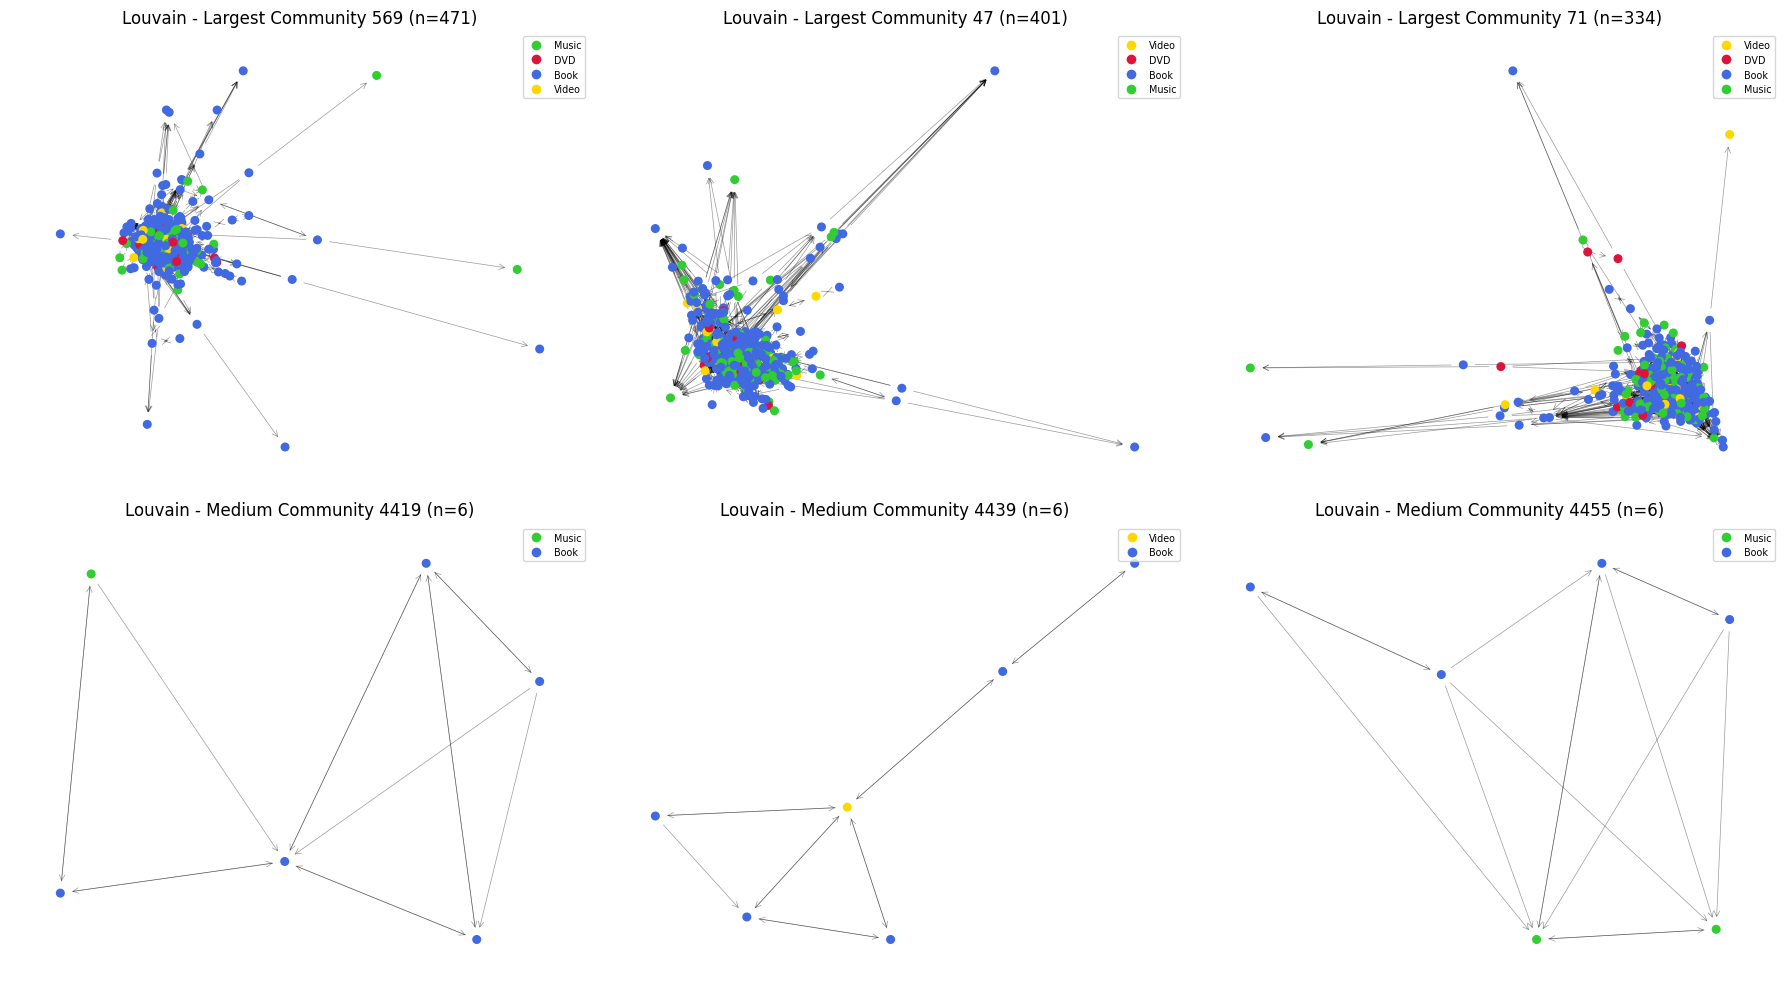

In [113]:
visualize_community_sample(G, lpa_communities, "LPA", max_nodes=500)

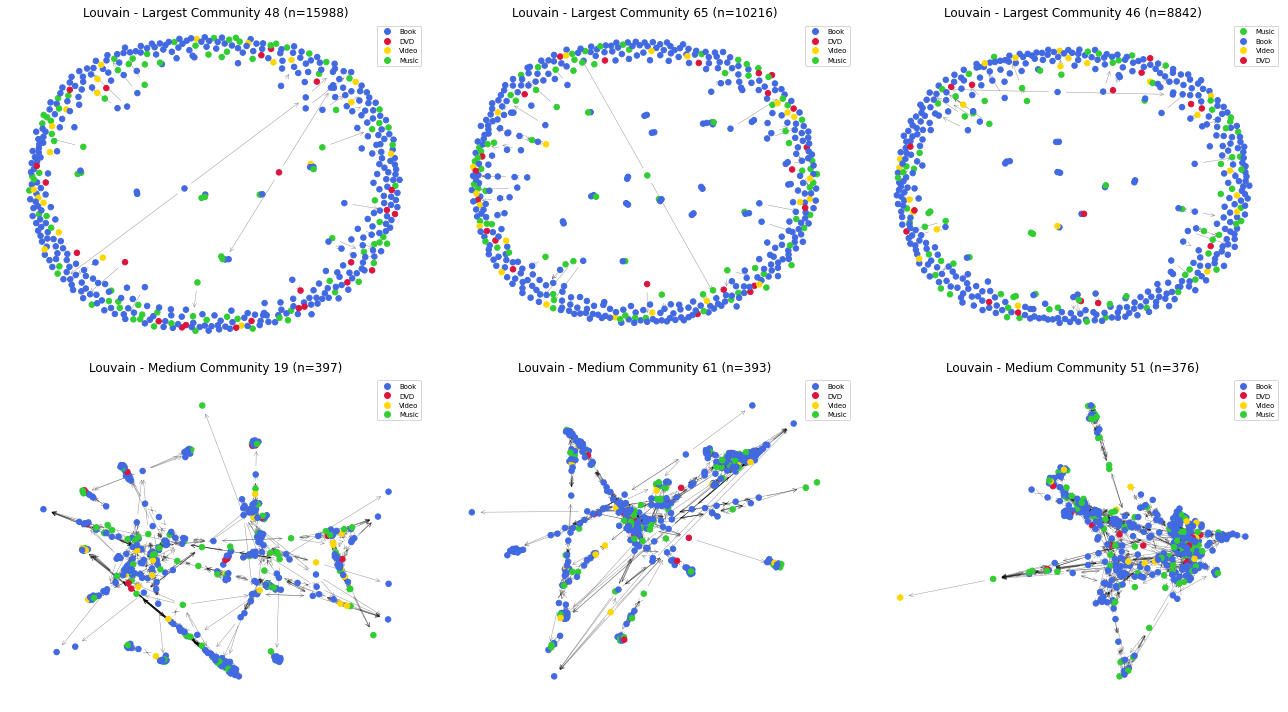

In [31]:
visualize_community_sample(G, louvain_communities, "Louvain", max_nodes=500)

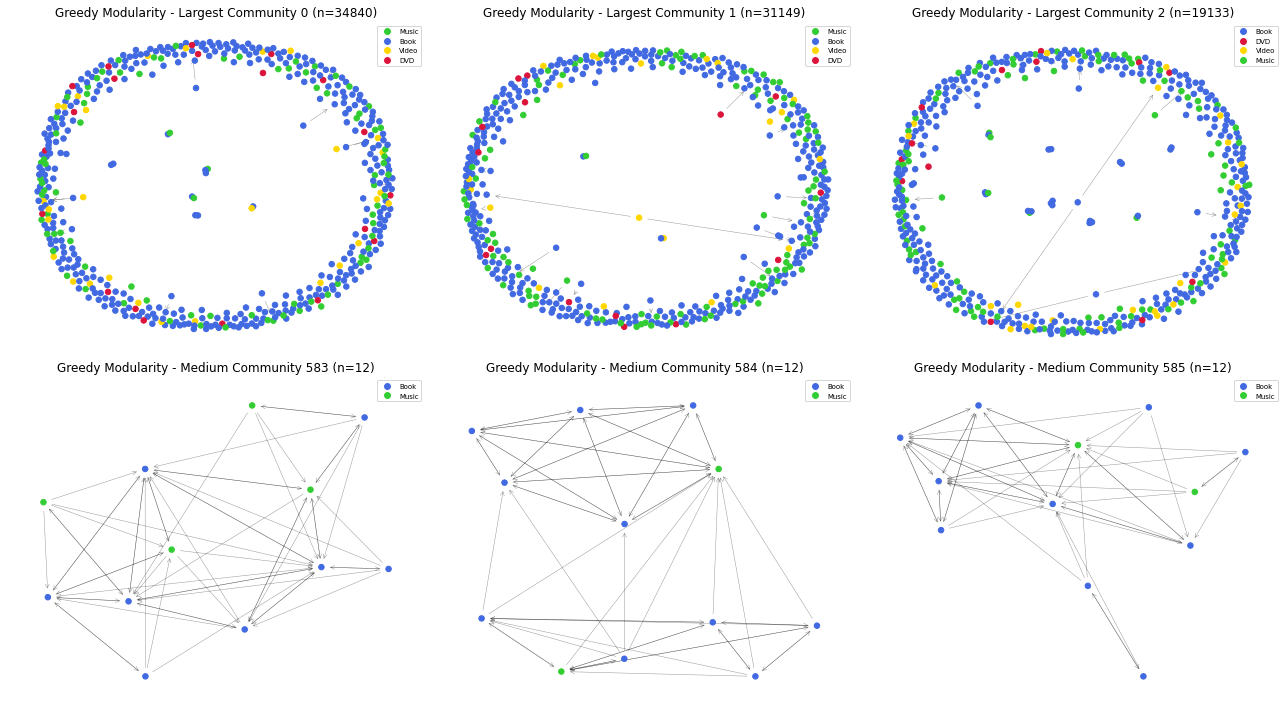

In [32]:
visualize_community_sample(G, greedy_modularity, "Greedy Modularity", max_nodes=500)

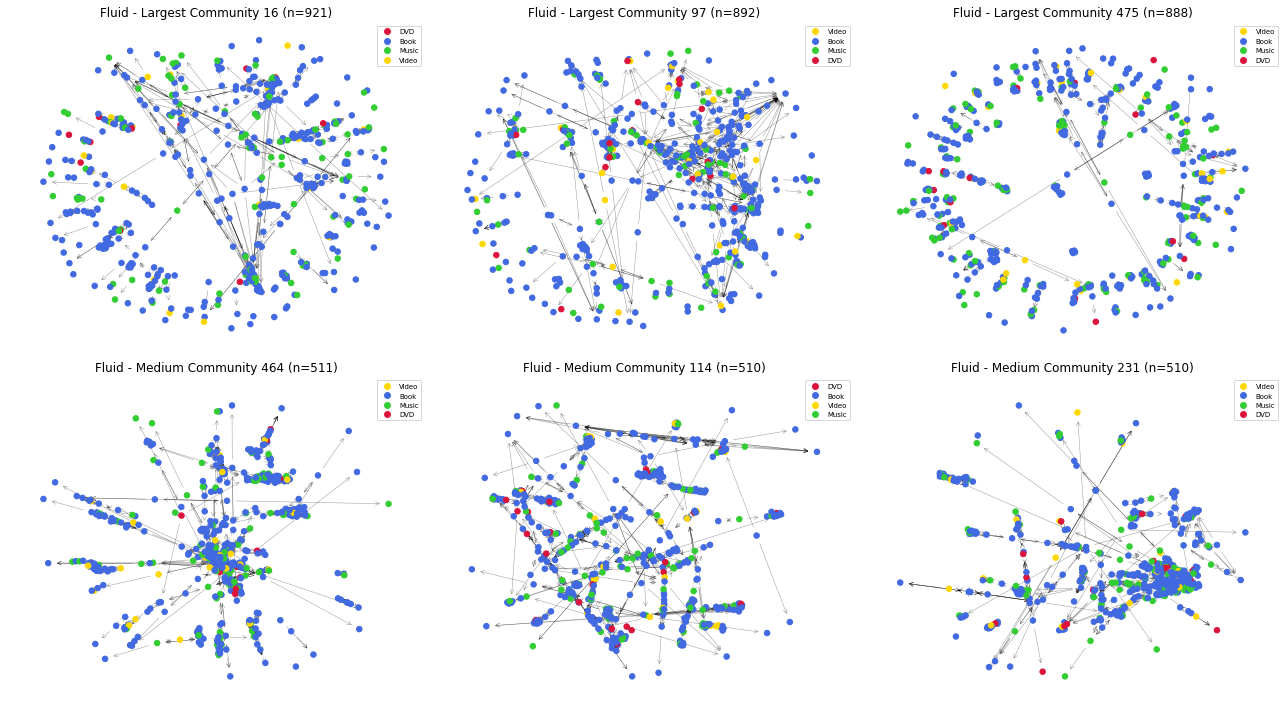

In [45]:
visualize_community_sample(G, fluid_community, "Fluid", max_nodes=500)

In [ ]:
# TODO: Add Community column to products_cleaned_engineered.csv
# TODO: Add community attribute to graph nodes and export the graph to xml and graphml